# Binôme : EZRA Seunkam et BOISSEAU Théo

## Définition du sujet

### Le cours du Bitcoin

Dans les fichiers Cotations2021.csv et Cotations2020.csv se trouvent l'évolution journalière du cours du Bitcoin en 2021 et en 2020. Ces fichiers contiennent 5 colonnes :
 - Date : jour de la cotation,
 - Ouverture : valeur en euros du cours du Bitcoin à l'ouverture du marché,
 - Plus Haut : valeur en euros la plus élevée du Bitcoin durant le jour considéré,
 - Plus Bas : valeur en euros la plus basse du Bitcoin durant le jour considéré,
 - Clôture : valeur en euros du cours du Bitcoin à la clôture du marché.

La notion de "cours du Bitcoin" est assez vague : finalement, on se pose vraiment la question de savoir combien vaut le Bitcoin au moment où on doit en acheter ou en vendre... Pour simplifier un peu, nous considérerons que d'un jour $t$ à un jour $(t+1)$ le cours du Bitcoin augmente (diminue) si sa valeur à la clôture au jour $t$ est inférieure (supérieure) à sa valeur à la clôture au jour $(t+1)$. 

Autrement dit, on va regarder la colonne "Clôture" pour décider de l'augmentation ou la baisse du cours du Bitcoin. 

### Enoncé du problème de classification

Le problème que nous avons à résoudre est donc un problème de classification : pour un jour $t$ donné, nous voulons prédire si à $(t+1)$ le cours va augmenter (classe 1) ou diminuer (classe 2). Le cas, marginal, ou le cours reste constant sera assimilé à la classe 2.

Pour réaliser cette prédiction, nous pouvons prendre en compte l'historique du cours sur les $h$ derniers jours. Quelle valeur de $h$ considérer ? Quelle(s) donnée(s) considérer sur les jours précédents : uniquement la valeur de clôture ou ... ?

### Démarche

1. Définir la notion d'historique : quel vecteur de données allons nous prendre en compte pour l'apprentissage et la prédiction ensuite ? Notons $\vec v$ ce vecteur.
1. Définir le problème d'optimisation à résoudre (fonction $H(\vec v)$ de séparation des données, fonction d'activation (sigmoide), fonction de perte/erreur),
2. Définir le gradient,
3. Créer notre algorithme de descente,


## Développement de notre algorithme de descente

### Outils
- La bibliothèque [pandas](https://pandas.pydata.org/docs/user_guide/index.html) est idéale pour l'utilisation d'une base de donnée.
- La bibliothèque [numpy](https://numpy.org/doc/1.18/user/index.html) est parfaite pour tout calcul sur des vecteurs.
- La bibliothèque [matplotlib](https://matplotlib.org/contents.html) est la base pour visualiser des résultats mais accouplé à [seaborn](https://seaborn.pydata.org/index.html) il est possible d'aller plus vite.
- Le bibliothèque [math](https://docs.python.org/fr/3.9/library/math.html) est souvent oubliée tellement elle semble évidente.

In [939]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import random as rd

### Lecture des données

La première tâche à réaliser va être de développer une fonction qui va lire un fichhier .csv contenant un historique de cotations et créer une base panda. La structure $RawData$ va contenir les données telles que contenues dans le fichier .csv passé en paramètre (selon la syntaxe décrite précédemment). De même, $RawC$ va contenir l'appartenance aux classes 1 (diminution) / 0 (augmentation).

In [940]:
#Input: nom du fichier .csv à lire.
#Nécessite :les lignes du fichier sont classées par dates de cotatation croissantes et les colonnées séparées par ";"
#Output: RawData, contient l'historique des cotations telles que lues dans le .csv
#        RawC, contient pour chaque ligne/date t (sauf la dernière) 1 si le cours baisse à t+1; 0 sinon.
def LireDonnees(NomFichier):
    #Lecture des données dans le fichier csv
    RawData=pd.read_csv(NomFichier, sep=';')
    
    #Construction des classes d'appartenance de chaque ligne de la base: on suppose que les cotations journalières sont
    #classées par ordre chronologique
    RawC=[]
    for index in range(len(RawData)-1):
        value=RawData.iloc[index,4] > RawData.iloc[index+1,4]
        value=1*value
        RawC.append(value)
    return RawData, RawC
    

### Définition des données utilisées pour l'apprentissage/prédiction

Nous allons maintenant définir une méthode qui va préparer une structure de données, nommée $data$, qui va contenir pour chaque ligne un couple :

$\vec v=(\vec x ; c_x)$

où $\vec x$ est le vecteur caractérisant la ligne en cours. Par exemple, pour la ligne $t$, date de cotation $t$, ce qui explique la prédiction $c$ (baisse/augmentation de la valeur de la cotation à $t+1$) c'est le cours du Bitcoin à la clôture sur les $h=3$ derniers jours. Donc, la ligne d'indice 0 dans $data$ va contenir :

$(x_1,x_2,x_3, c_x=0$ ou $1)$ 

avec $x_j$ la valeur de cotation à la clôture le jour $j$.


In [941]:
def EquilibrerData(RawData,RawC):
    # On crée un nouveau dataset équilibré
    RawDataEquilibre = RawData.copy()
    RawCEquilibre = RawC.copy()

    Cdf = pd.DataFrame(RawC)
    zero = Cdf.loc[Cdf[0] == 0] # On identifie les 0 de RawC
    un = Cdf.loc[Cdf[0] == 1] # On identifie les 1 de RawC

    # On cible les lignes du dataset qu'il faut enlever pour avoir autant de 0 que de 1
    indexASupprimer = []
    if len(zero) > len(un):
        indexASupprimer = zero.sample(n=len(zero.index) - len(un.index)).index.tolist()
    if len(un) > len(zero):
        indexASupprimer = un.sample(n=len(un.index) - len(zero.index)).index.tolist()

    # On effectue la suppression
    if indexASupprimer != []:
        indexASupprimer.sort()
        RawDataEquilibre.drop(index=indexASupprimer, inplace=True)
        RawDataEquilibre.reset_index(drop=True, inplace=True)
        for iterateur in range(len(indexASupprimer)):
            RawCEquilibre.pop(indexASupprimer[iterateur] - iterateur)

    return RawDataEquilibre, RawCEquilibre

In [942]:
#Input: RawData et RawC ont été créés à partir d'un fichier .csv
#Output: D, contient les points $(\vec x)$. Cela doit être une matrice numpy
#        C, contient la classe d'appartenance $c_x$ de chaque entrée dans data. Cela doit être un vecteur numpy
def CreerData(RawData,RawC):
    (RawDataEquilibre,RawCEquilibre) = EquilibrerData(RawData,RawC) # On équilibre le dataset pour avoir autant de 0 que de 1

    h = 6
    pas = 3
    variables = ("Ouverture", "Plus Haut", "Plus Bas", "Cloture") # On sélectionne les variables désirées
    std = RawDataEquilibre.std(axis=1,numeric_only=True) # On calcule l'écart type à chaque date
    moy = RawDataEquilibre.mean(axis=1,numeric_only=True)  # On calcule l'espérance à chaque date

    nbDates = len(RawDataEquilibre.index) - h*pas
    D = np.empty((nbDates, h*len(variables)))
    for t in range(nbDates): # On va instancier chaque vecteur x
        for p in range(h): # En écrivant le point x_(t+p)
            for pVar in range(len(variables)): # et pour chacun, chacune de ses variables
                # On normalise de façon à centrer normer chaque donnée d'un même jour.
                D[t][pVar + p*len(variables)] = (RawDataEquilibre[variables[pVar]][t+p*pas] - moy[t+p*pas]) / std[t+p*pas]
    if -h*(pas-1) != 0 :
        C = np.array(RawCEquilibre)[h-1:-h*(pas-1)]
    else:
        C = np.array(RawCEquilibre)[h-1:]

    return(D,C)

(RawData,RawC)=LireDonnees("Cotations2020.csv")
(D,C)=CreerData(RawData,RawC)

### Définition du problème d'optimisation à résoudre

On a choisi
$\vec v=(\vec x ; c_x) \in R ^{ 4h +1}, \ avec \ \forall i \in \{1..h\}, \ \vec x_i \in R^4$ étant l'ensemble des valeurs des variables sélectionnées du point $\vec x_i$

$H(\vec v) = \displaystyle\sum_{i=1}^{h} \vec w_i \cdot \vec x_i + b, \ avec \ h = 3 \ et \ \forall i \in \{1..h\}, \ \vec w_i \in R^4$

D'où $H(\vec v) = \vec w_1 \cdot \vec x_1 + \vec w_2 \cdot \vec x_2 + \vec w_3 \cdot \vec x_3 + b$

On concatennera les $\vec x$ pour chaque $\vec v$ dans la matrice D, les $c_x$ seront stockés dans le vecteur colonne C, et on concatennera les $\vec w_i$ dans le vecteur weights.

On va utiliser la fonction logistique sigmoide pour transformer les valeurs de $H(\vec v)$ en valeurs $0$ ou $1$:

$\mathcal{S}: x \mapsto \frac{1}{1+\exp^{-\lambda x}}$.

Notre classificateur est donc : $\mathcal{S}(H(\vec v))$.

Pour notre problème, on cherche à apprendre sur la base d'apprentissage les valeurs de $\vec w_i \ \forall i \in \{1..h\}$ et $b$.

On choisit la cross-entropy pour mesurer l'erreur de notre problème, c'est à dire la distance entre $\mathcal{S}(H(\vec v))$ et $c_{\vec v}$ :

$E(\mathcal{P}) = \sum \limits_{\vec v \in \mathcal{P}}-(c_{\vec v}\log_2(\mathcal{S}(H(\vec v)))+(1-c_{\vec v})\log_2(1-\mathcal{S}(H(\vec v))))$.

$\mathcal{P} : \Bigg\{$
$\  Minimiser \ E(P)$
$\ \ s.c.$
$\ \ \vec w_i \in R^4 \ et \ b \in R$
$\Bigg\}$

Commençons par définir le code qui calcule $H(\vec v)$ puis le code de la fonction logistique sigmoid $\cal{S}(x)$. Je suppose que vous allez reprendre les mêmes fonctions que dans le TP introductif, mais si vous voulez changer vous pouvez, bien sûr ! 

In [943]:
# définition de la méthode pour calculer H(v)
def H(weights, constant, point):
    value=np.sum(weights*point)+constant
    return value

Définissons maintenant le code qui calcule $\mathcal{S}(x)$.

In [944]:
# définition de la fonction sigmoide (logistique) et la fonction d'arrondie
def Sigmoid(x, lamda=0.001):
        return 1/(1+np.exp(-lamda*x))


def Step_function(x):
        return 1*(x>=0)

Passons maintenant à la définition de la fonction d'erreur $E(\mathcal{P})$, qui est notre fonction à minimiser, ainsi que du gradient.

In [945]:
# définition de la méthode pour calculer l'erreur 
#Input : weights, le vecteur de poids utilisés dans la fonction H,
#        constant, la constante utilisée dans la fonction H
#Output : une valeur numérique, l'erreur commise. 
def Loss_function(weights, constant):
    loss_value = 0
    for index in range(len(D)):
        p = D[index:index+1,:]
        c = C[index]
        loss_value -= c*np.log2(Sigmoid(H(weights, constant, p)))+(1-c)*np.log2(1-Sigmoid(H(weights, constant, p)))
    return loss_value

In [946]:
# définition du calcul de gradient
#Input : weights, le vecteur de poids utilisés dans la fonction H,
#        constant, la constante utilisée dans la fonction H
#Output : le gradient, un numpy array
def Gradient(weights, constant):
    grad = []
    # Looping over all variables (number of variables=number of weights)
    for w in range(len(weights)):
        coord_value=0
        for index in range(len(D)):
            x=D[index:index+1,:]
            coord_value-= x[0,w]*(C[index]-Sigmoid(H(weights, constant, x)))
        grad.append(coord_value)
    coord_value=0
    # Considering the last component=constant
    for index in range(len(D)):
        x=D[index:index+1,:]
        coord_value-= (C[index]-Sigmoid(H(weights, constant, x)))
    grad.append(coord_value)
    return np.array(grad)

### Algorithme de descente

Avant de procéder à l'apprentissage, nous avons dans un premier temps équilibré la base (pour avoir autant de "0" que de "1"), puis centré et réduit les données date par date, sinon l'algorithme prédisait 100% de zéros ou 100% d’uns. En ayant testé plusieurs combinations de h (la fenêtre de jours) et de p (le pas entre les jours), on a trouvé que **h = 6** jours (à peu près 1 semaine) et **pas = 3** jours marchaient le mieux.  En prenant les h=3 derniers jours comme c’était le cas au début, on n’avait pas beaucoup d’information sur la période dans laquelle le jour à prédire était situé.

Avec cette base d’apprentissage, et en prenant **1000 itérations** et un **Learning rate de 1.2**, on obtient de meilleurs résultats. Après la normalisation des données, on a remarqué que le pas était devenu trop petit à cause du gradient qui avait beaucoup diminué, donc on a choisi un Learning rate beaucoup plus grand pour l’augmenter. En dessous de 1000 itérations, on n’apprend pas suffisamment et donc l’erreur est encore élevée, et au-delà de ça, l’algorithme ne peut pas très bien se généraliser pour prédire sur une nouvelle base.

Enfin, avoir un **lamda de 0.001** par rapport à la norme de notre gradient nous permet d'avoir des valeurs de la sigmoide proches de 0.5. Cela permet de faire évoluer les poids plus facilement lors du calcul du gradient et de mieux estimer l'erreur, ce qui permet également d'améliorer les prédictions.


In [ ]:
# L'algorithme de gradient qui va travailler à partir des structures numpy D et C
# Input :
# Nécessite :
# Output : weights, un numpy array contenant les poids utilisés dans la fonction de séparation H 
#          constant, un numérique contenant la constante utilisée dans la fonction de séparation H
#          nbstep, nombre d'itérations mises par l'algorithme avant de s'arrêter

def Algorithme_Gradient():
    
   #Initialisations pour les graphiques terminaux: à conserver
    ## Produire deux graphes cote à cote 2 subplots
    fig, ax = plt.subplots(figsize=(10, 5) , nrows=1, ncols=1)
    ## Pour visualiser les evolutions en fonction du step
    itersteps = []
    ## Pour visualiser l'evolution de la norme du gradient
    iterGap = []
    ## Pour visualiser l'évolution de l'erreur
    iterError = []
    ## Pour visualiser la séparation linéaire
    #line_X = np.array([min(data["x"]), max(data["x"])])
    
    #Initialisation de l'algorithme du gradient 
    ## initialise les poids et la constante
    weights = np.random.random(np.shape(D)[1])
    constant = rd.random()
    ## initialise le pas d'optimisation
    learning_rate = 1.2
    #Initialisation du pas d'itération
    nbstep = 1000
    step = 1 # numéro d'itération dans l'algorithme

    # Exécution de l'algorithme de gradient
    while step < nbstep:
        
        # Calcul de la fonction de perte/erreur
        E = Loss_function(weights,constant)

        # Calcul du gradient et de sa norme
        total_grad = Gradient(weights,constant)

        norm = np.linalg.norm(total_grad)
        # Mise à jour des poids et de la constante
        weights-=(learning_rate*total_grad[:-1])/norm
        constant-=learning_rate*total_grad[-1]/norm

        # Stockage de valeurs à cette itération pour affichage final
        itersteps.append(step - 1)
        iterGap.append(norm)
        iterError.append(E)
            
        step += 1

    # Affichage final : à conserver
    ax.plot(itersteps,iterGap, label='Norme du gradient')
    ax.plot(itersteps,iterError, label='Erreur')
    ax.set_xlabel('step')
    ax.legend()
    plt.show()
    
    return(weights,constant,nbstep)


## Phase d'apprentissage 

* La fonction LireDonnees() doit être appelée pour lire des données brutes dans un fichier .csv qui est notre base d'apprentissage,
* La fonction CréerData() doit être appelée pour créer les structures $D$ et $C$ qui sont utilisées par notre algorithme de gradient,
* L'algorithme de gradient.

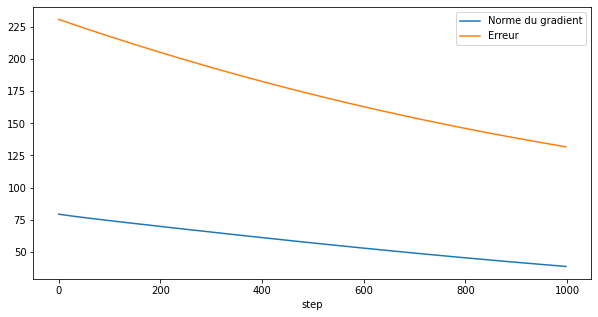

In [948]:
(RawData,RawC)=LireDonnees("Cotations2021.csv")
(D,C)=CreerData(RawData,RawC)
(weights,constant, nbstep)=Algorithme_Gradient()

## Construction du prédicteur

In [949]:
# Input: weights, les poids appris pendant l'apprentissage
#       constant, la constante apprise pendant l'apprentissage
#       v, le vecteur à partir duquel on veut prédire
# Nécessite : que l'apprentissage ait été fait, i.e. on dispose de weights et constant
# Output : le résultat de la prédiction
def Prediction(weights, constant, v):
    if Sigmoid(H(weights, constant, v))>0.5:
            return 1
    else: 
            return 0

Généralisons ce prédicteur pour l'évaluer sur une base de vecteurs $\vec v$

In [950]:
# Input: weights, les poids appris pendant l'apprentissage
#       constant, la constante apprise pendant l'apprentissage
#       D, une base de données de vecteurs à partir duquel on veut prédire
# Nécessite : que l'apprentissage ait été fait, i.e. on dispose de weights et constant
# Output : Cpred, le vecteur des prédictions associées

def PredictionsOnBase(weigths,constant,D):
    Cpred=[]
    for index in range(len(D)):
        Cpred.append(Prediction(weights,constant,D[index:index+1,:]))
    return Cpred

## Evaluation du prédicteur sur la base d'apprentissage

Le code ci-dessous permet d'évaluer la qualité du prédicteur sur la base d'apprentissage, autrement dit:
- Calcul du pourcentage de bonnes classifications,
- Matrice de confusion : vous donnera la répartition des bonnes/mauvaises classifications.

In [951]:
Cpred=PredictionsOnBase(weights,constant,D)
GoodPred=0
VraiPositifs=0
FauxPositifs=0
VraiNegatifs=0
FauxNegatifs=0
NumberPositif=0
for index in range(len(C)):
    if (C[index]==1): 
        NumberPositif +=1
    if (C[index]==Cpred[index]):
        GoodPred+=1
    if (C[index]==1):
        if (Cpred[index]==1):
            VraiPositifs+=1
        else:
            FauxNegatifs+=1
    if (C[index]==0):
        if (Cpred[index]==1):
            FauxPositifs+=1
        else:
            VraiNegatifs+=1
print("Taux de bonnes classifications : ",100.0*GoodPred/len(C),"%")
print("Quand il fallait prédire 1...")
print(100.0*VraiPositifs/NumberPositif,"% du temps le prédicteur prédit 1")
print(100.0*FauxNegatifs/NumberPositif,"% du temps le prédicteur prédit 0")
print("Quand il fallait prédire 0...")
print(100.0*VraiNegatifs/(len(C)-NumberPositif),"% du temps le prédicteur prédit 0")
print(100.0*FauxPositifs/(len(C)-NumberPositif),"% du temps le prédicteur prédit 1")

Taux de bonnes classifications :  94.8051948051948 %
Quand il fallait prédire 1...
94.69026548672566 % du temps le prédicteur prédit 1
5.3097345132743365 % du temps le prédicteur prédit 0
Quand il fallait prédire 0...
94.91525423728814 % du temps le prédicteur prédit 0
5.084745762711864 % du temps le prédicteur prédit 1
